<a href="https://colab.research.google.com/github/sebastiant93/Reto--Machine-learning-con-Pytorch/blob/main/SebastianTorresFranco_reto_C7SC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reto | Modelo basado de Deep Learning para la discriminación entre gatos y perros
------------

##Presentado a: José Antonio Cantoral Ceballos
##Presentado por: Sebastián Torres Franco

# 1 Analiza la base de datos
Analiza la base de datos del archivo Catsvsdogs.zip.

## Conclusiones

Se realiza el análisis de la base de datos mediante el siguiente procedimiento:
* Inspección de los directorios dentro de la carpeta de imágenes
* Conteo de imágenes por directorio
* Separación en subdirectorios según especie y raza
* Impresión de muestras para algunas razas de perros y gatos

In [ ]:
#********************************* Importación de librerías

#************** Librerías de procesamiento
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import random

#************** Librerías para creación de datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.datasets as datasets
import torchvision.io as io

#************** Librerías de visualización
import matplotlib.pyplot as plt
import PIL
from PIL import Image

#************** Librerías para inspección de directorios
import pathlib
import os
from collections import Counter
import re
import shutil #Para copiar archivos entre directorios

#************** Librerías para guardar información en caso de desconexión
import pickle

#************** Librerías para imprimir Summary del modelo
from torchsummary import summary



In [ ]:
#********************************* Se revisa el posible acceso a recurso GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: ', {device})

Using device:  {device(type='cuda')}


In [ ]:
#********************************* Conexión a google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##1.1 Verificación de subdirectorios

Se verifican los subdirectorios en la carpeta de reto

In [ ]:
#******************************** Verificación subdirectorios
!ls "/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs"

cats  dogs


## 1.2 Conteo de archivos

Se exploran los tipos de imágenes en los directorios. Al final, se realiza un conteo de los archivos de cada directorio de acuerdo con su extensión

In [ ]:
#********************************* Definición de funciones
def get_extension(path,dir_id):
    '''
    Descripción
        Función encargada de formar un diccionario de conteo con las extensiones de los archivos contenidos en un directorio con ruta "path"
    Inputs:
        * path: Ruta del directorio a inspeccionar
        * dir_id: string usado para impresión de resultado. Contiene el ID de la ruta ()
    Returns:
        * None
    '''

    ext_list=[] #Se crea la lista para concatenar las extensiones de los archivos

    for archivo in os.listdir(path): #Se recorre el directorio tomando y almacenando la extensión de cada archivo
        name_file,ext_file=os.path.splitext(archivo)
        ext_list.append(ext_file)

    #Se crea un directorio de la forma {extensión:conteo}
    counter_ext=Counter(ext_list)
    print(f"\n ****************** Listado extensiones directorio {dir_id} ******************")
    print(counter_ext)

#************************************************************************************************************************

#******************************* 1) Conteo total de imagenes en la base de datos
#*************** Toma directorios base y de cada una de las clases
DirBase="/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs"
DirBase=pathlib.Path(DirBase)

DirC1="/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs/cats" # Directorio de archivos para gatos
DirC2="/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs/dogs" # Directorio de archivos para perros

#*************** Conteo de archivos total y por directorio
#******* Cantidad total de archivos
print("Cantidad de archivos el dataset: ",len(list(DirBase.glob("*/*")))) #Impresión de total de archivos

#******* Cantidad por directorio
#Lista con los id de los directorios a imprimir
lista_ids=["cats","dogs"]

for id in lista_ids: #Impresión de total de archivos por directorio
    print(f"Cantidad de archivos en el directorio {id}:",len(list(DirBase.glob(f"*{id}/*"))))

#******************************* 2) Revisión de los tipos de archivo por directorio

list_dirs=[DirC1,DirC2] #Se almacenan los diccionarios en una lista
for path, id in zip(list_dirs,lista_ids):
    get_extension(path,id) #Se ejecuta función para verificar el tipo de archivo por directorio


Cantidad de archivos el dataset:  4900
Cantidad de archivos en el directorio cats: 2404
Cantidad de archivos en el directorio dogs: 2496

 ****************** Listado extensiones directorio cats ******************
Counter({'.jpg': 2400, '.mat': 3, '': 1})

 ****************** Listado extensiones directorio dogs ******************
Counter({'.jpg': 2495, '': 1})


## 1.3 Separación de archivos en categorías

Considerando que las imagenes no están clasificadas en razas por carpetas, Se crean subcarpetas de acuerdo con las razas de perros y gatos. Se etiqueta cada imagen dentro de su respectiva carpeta

In [ ]:
#********************************* Definición de funciones
def remove_ext (list_of_words):
    '''
    Descripción:
        Función encargada de eliminar la extensión y id numérico de los archivos

    Inputs:
        list_of_words: lista de palabras separadas para el archivo

    Output:
        * Update: list_of_words: listado actualizado sin el id numérico ni la extensión
    '''
    for word in list_of_words:             # Se recorren las palabras de la lista
        if "." in word:                    # Se verifica la posición de la extensión con el caracter "."
            list_of_words.remove(word)     # Se elimina la extensión y el id numérico
    list_of_words="_".join(list_of_words)  # Se concatenan las palabras usando "_" como separador

    return list_of_words                   # Se retorna lista actualizada

def create_folders(path,base_dir):
    '''
    Descripción:
        Función encargada de 1) crear subdirectorios con los nombres únicos de las razas contenidas en los nombres de los archivos en la ruta path
                             2) Generar una lista con los valores únicos de razas contenidos en un directorio
                             3) Generar una lista con la raza de cada imagen
    Input:
        * path: Ruta con los nombres de las razas
        * base_dir: Ruta donde se crearán los subdirectorios con las razas de la especie

    Output:
        list_of_races: Lista con valores únicos de las razas identificadas para cada archivo en el subdirectorio
        race_of_files: Lista de raza por archivo
    '''

    list_of_files=os.listdir(path)                                  # Se toman los archivos de la ruta y se concatenan en una lista
    split_text=list(map(lambda x: re.split("_| ",x),list_of_files)) # Se separan las palabras usando "_" como delimitador para eliminar la extensión del archivo
    race_of_files=list(map(lambda x: remove_ext(x),split_text))       # Se crea una nueva lista con el nombre de las razas de cada archivo (Llamado de función)
    list_of_races=set(race_of_files)                                # Listado con valores únicos de las razas

    for race in list_of_races: #Se crean los directorios con las razas
        os.mkdir(f"{base_dir}/{race}")

    return race_of_files, list_of_races


#******************************************************************************************

#********************************* Se generan listas y folders con las razas de perros y gatos

os.mkdir(f"{DirBase}/separated_sets") #Se crea el directorio donde se separarán las razas de perros y gatos

#******* gatos
cat_basedir=f"{DirBase}/separated_sets/cats"
os.mkdir(cat_basedir) #Directorio donde se almacenarán las razas de gatos
cat_race_files,cat_race= create_folders(DirC1,cat_basedir)

#******* perros
dog_basedir=f"{DirBase}/separated_sets/dogs"
os.mkdir(dog_basedir) #Directorio donde se almacenarán las razas de perros
dog_race_files,dog_race= create_folders(DirC2,dog_basedir)


In [ ]:
#********************************* Muestas de resultados
#Se muestran los resultados de las listas obtenidas, y de los nuevos directorios generados
print("********* Muestra de resultados para razas gatos **********")
print("Muestra de razas tomadas de archivos",cat_race_files[0:10])
print("Razas de gatos detectadas:",cat_race)

print("\n")
print("********* Muestra de resultados para razas perros **********")
print("Muestra de razas tomadas de archivos",dog_race_files[0:10])
print("Razas de perros detectadas:",dog_race)

********* Muestra de resultados para razas gatos **********
Muestra de razas tomadas de archivos ['Maine_Coon', 'Persian', 'British_Shorthair', 'Bombay', 'Persian', 'Persian', 'Russian_Blue', 'Bengal', 'British_Shorthair', 'Persian']
Razas de gatos detectadas: {'British_Shorthair', 'Bombay', 'Birman', 'Siamese', 'Abyssinian', 'Russian_Blue', 'Bengal', 'Sphynx', 'Egyptian_Mau', 'Ragdoll', 'Maine_Coon', 'Persian'}


********* Muestra de resultados para razas perros **********
Muestra de razas tomadas de archivos ['pomeranian', 'boxer', 'leonberger', 'chihuahua', 'american_pit_bull_terrier', 'staffordshire_bull_terrier', 'saint_bernard', 'american_bulldog', 'samoyed', 'japanese_chin']
Razas de perros detectadas: {'boxer', 'leonberger', 'samoyed', 'english_cocker_spaniel', 'german_shorthaired', 'basset_hound', 'havanese', 'keeshond', 'american_pit_bull_terrier', 'american_bulldog', 'japanese_chin', 'pug', 'wheaten_terrier', 'staffordshire_bull_terrier', 'newfoundland', 'scottish_terrier', 

In [ ]:
#********************************* Muestas de resultados
#Se muestran los nuevos directorios creados
print("Muestra de nueva carpeta separated_sets")
!ls "/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs"

print("\nMuestra de nuevas subcarpetas separadas por especie")
!ls "/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs/separated_sets"

print("\nMuestra de subcarpetas creadas para las razas de gatos")
!ls "/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs/separated_sets/cats"

print("\nMuestra de subcarpetas creadas para las razas de perros")
!ls "/content/gdrive/MyDrive/Subasta CxC/Otros/Pytorch/Reto/Catsvsdogs/catsvsdogs/separated_sets/dogs"



Muestra de nueva carpeta separated_sets
cats  dogs  separated_sets

Muestra de nuevas subcarpetas separadas por especie
cats  dogs

Muestra de subcarpetas creadas para las razas de gatos
Abyssinian  Birman  British_Shorthair  Maine_Coon  Ragdoll	 Siamese
Bengal	    Bombay  Egyptian_Mau       Persian	   Russian_Blue  Sphynx

Muestra de subcarpetas creadas para las razas de perros
american_bulldog	   english_setter      miniature_pinscher  shiba_inu
american_pit_bull_terrier  german_shorthaired  newfoundland	   staffordshire_bull_terrier
basset_hound		   great_pyrenees      pomeranian	   wheaten_terrier
beagle			   havanese	       pug		   yorkshire_terrier
boxer			   japanese_chin       saint_bernard
chihuahua		   keeshond	       samoyed
english_cocker_spaniel	   leonberger	       scottish_terrier


In [ ]:
#********************************* Definición de funciones
def copy_files(source,base_dir,race_files):
    '''
    Descripción:
        Función encargada de copiar archivos de un path "source" a un path "dest"

    Inputs:
       * source: path de donde se copiará el archivo
       * base_dir: Directorio de la especie (Contiene los subfolders por raza)
       * race_files: Lista con la raza asignada a cada imagen (Se usa para asignar al respectivo directorio)

    Outputs:
       * None
    '''
    cont=0                                           # Contador para recorrer la lista race_files en la asignación de los archivos
    for file_name in os.listdir(source):             # Se realiza el proceso para cada archivo en el directorio fuente
      file_path = f"{source}/{file_name}"            # Se genera la ruta del archivo a copiar
      destination = f"{base_dir}/{race_files[cont]}" # Se genera la ruta destino del archivo
      shutil.copy(file_path, destination)            # Se copia el archivo de fuente a destino
      cont=cont+1                                    # Se aumenta el contador para pasar a la raza de la siguiente imagen

#*****************************************************************************************

#********************************* Se copian los archivos a los nuevos subdirectorios clasificados por raza
copy_files(DirC1,cat_basedir,cat_race_files) # Archivos para imágenes de gatos
copy_files(DirC2,dog_basedir,dog_race_files) # Archivos para imágenes de perros




In [ ]:
#********************************* Muestas de resultados
#Se exploran los archivos en los nuevos subdirectorios


print("********************************* Exploración de los nuevos subdirectorios para gatos *********************************")
print("Cantidad de archivos el dataset: ",len(list(pathlib.Path(cat_basedir).glob("*/*")))) #Se explora la cantidad de archivos repartidos en subdirectorios por raza
for race in cat_race : #Exploración de archivos para razas de gatos
    path=f"{cat_basedir}/{race}" #Se genera la ruta del subdirectorio a inspeccionar
    get_extension(path,race)     #Se llama función para exploración de archivos

print("\n********************************* Exploración de los nuevos subdirectorios para perros *********************************")
print("Cantidad de archivos el dataset: ",len(list(pathlib.Path(dog_basedir).glob("*/*")))) #Se explora la cantidad de archivos repartidos en subdirectorios por raza
for race in dog_race : #Exploración de archivos para razas de gatos
    path=f"{dog_basedir}/{race}" #Se genera la ruta del subdirectorio a inspeccionar
    get_extension(path,race)     #Se llama función para exploración de archivos


********************************* Exploración de los nuevos subdirectorios para gatos *********************************
Cantidad de archivos el dataset:  2404

 ****************** Listado extensiones directorio British_Shorthair ******************
Counter({'.jpg': 200})

 ****************** Listado extensiones directorio Bombay ******************
Counter({'.jpg': 200})

 ****************** Listado extensiones directorio Birman ******************
Counter({'.jpg': 200})

 ****************** Listado extensiones directorio Siamese ******************
Counter({'.jpg': 200})

 ****************** Listado extensiones directorio Abyssinian ******************
Counter({'.jpg': 200, '.mat': 3})

 ****************** Listado extensiones directorio Russian_Blue ******************
Counter({'.jpg': 200})

 ****************** Listado extensiones directorio Bengal ******************
Counter({'.jpg': 200})

 ****************** Listado extensiones directorio Sphynx ******************
Counter({'.jpg': 200})


##1.4 Muestra de imágenes
Se generan algunas gráficas para verificar que la repartición de archivos en los nuevos subdirectorios haya sido apropiada

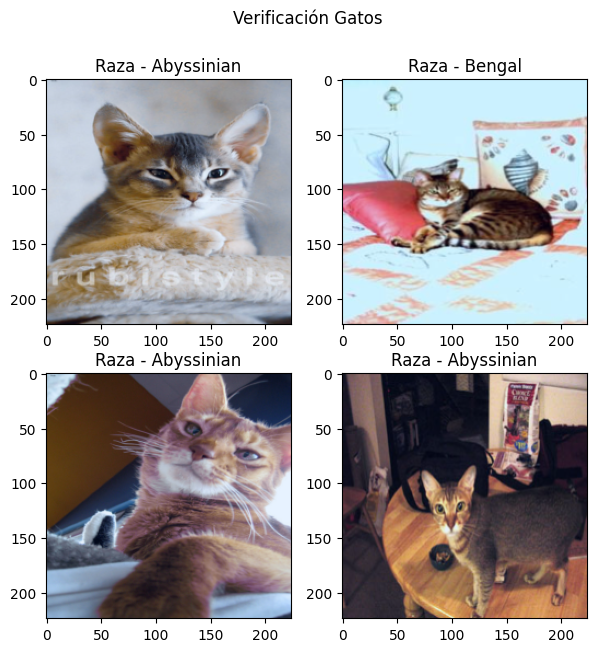

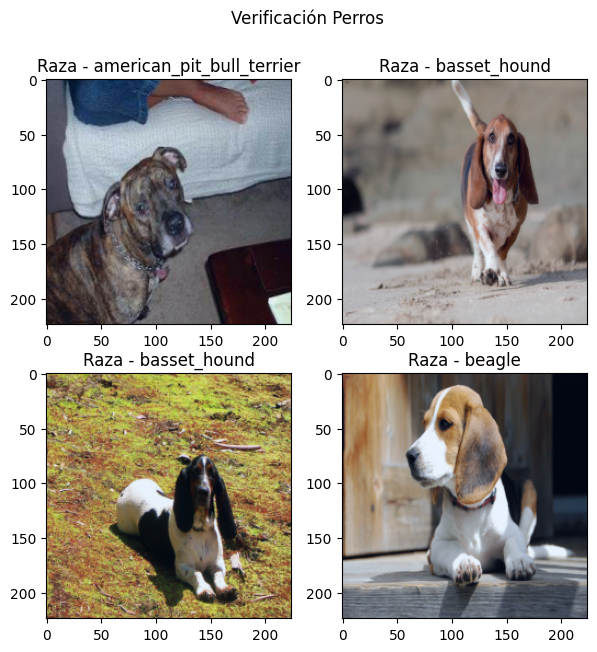

In [ ]:
#********************************* Definición de funciones
def sample_plot(path,title,races,batch_size):
    '''
    Descripción:
        Función encargada de generar un muestreo de imagen en un batch de 4 para un directorio en forma de subplot

    Inputs:
        * path: ruta del directorio con las imágenes
        * tile: Título del subplot
        * batch_size: Tamaño del batch
        * races: listado con razas
    Outputs:
        None
    '''
    races=list(races) # Se convierte el set de razas a lista
    races.sort()      # Se ordena la lista
    dataset = datasets.ImageFolder(path, transform=transform)                        # Se toma el dataset con las transformaciones especificadas para el objeto transform
    sample_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)        # Se crea el objeto de dataloader para el muestreo

    fig,axs=plt.subplots(2,2,figsize=(7,7))   # Se genera el subplot para e muestreo
    for i in range(2):
        for j in range(2):
            random_index=np.random.randint(batch_size)
            image=sample_loader.dataset[random_index][0]                # Se toma la imagen del batch
            image=(image - image.min()) / (image.max() -image.min() )   # Se escala el tensor en el rango 0-1
            axs[i,j].imshow(image.permute(1,2,0))                       # Se permutan los datos de la imagen para quedar en formato H,W,C
            raza=races[sample_loader.dataset[random_index][1]]          # Se toma la raza de la imagen
            axs[i,j].set_title(f"Raza - {raza}")
    plt.suptitle(title)
#********************************************************************************************

#Se genera un objeto con las transformaciones que se usarán para la inspección de archivos y entrenamiento
transform = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

sample_size=500 #Tamaño de la muestra a imprimir por subddirectorio

#******* Se realiza un muestreo aleatorio de imagenes para perros y gatos
sample_plot(cat_basedir,"Verificación Gatos",cat_race,sample_size) #Muestreo para gatos
print("\n")
sample_plot(dog_basedir,"Verificación Perros",dog_race,sample_size) #Muestreo para perros

#3 Implementa tu modelo

Implementa tu modelo y realiza las pruebas que consideres pertinentes.

##Conclusión del punto

Se implementa el modelo considerando los siguientes pasos:

* Definición de tamaños y separación de data en sets de entrenamiento, validación, y prueba.
* Definición de función para calculo de accuracy usando GPU
* Definición de loop de entrenamiento
* Definición de arquitectura de red considerando capas CNN, y ejecución del modelo
* Verificación de resultados.


## 3.1 Sets de entrenamiento, validación y prueba

Se defininen tamaños de 60%, 20%, y 20%, para los sets de entrenamiento, validación, y prueba respectivamente

In [ ]:
#********************************* Dfinición de tamaño para los sets de entrenamiento validación y prueba

#******* Se toma la ruta de trabajo para los data sets
full_data_path=f"{DirBase}/separated_sets"
full_data_set=datasets.ImageFolder(full_data_path,transform=transform)

#******* Se definine los tamaños de los sets
train_size=int(len(full_data_set) * 0.6)
val_size=int(len(full_data_set) * 0.2)
test_size=int(len(full_data_set) * 0.2)

print("Tamaño set de entrenamiento:",train_size)
print("Tamaño set de Validación:",val_size)
print("Tamaño set de Prueba:",test_size)

Tamaño set de entrenamiento: 2937
Tamaño set de Validación: 979
Tamaño set de Prueba: 979


In [ ]:
#********************************* Partición de los conjuntos
#******* Se asignan las imágenes de forma aleatoria para cada conjunto
training_set, val_set, test_set = random_split(full_data_set, [train_size, val_size, test_size])

#******* Se verifica que el tamaño de los conjuntos se haya asignado de forma correcta.
print("Tamño set de entrenamiento: ",len(training_set))
print("Tamaño set de validación: ",len(val_set))
print("Tamaño set de prueba: ",len(test_set))


Tamño set de entrenamiento:  2937
Tamaño set de validación:  979
Tamaño set de prueba:  979


In [ ]:
#********************************* Creación de objetos DataLoader
#Se toma batch de 50 imágenes
batch=50

#Se generan los obbjetos dataloader para los sets
training_loader=DataLoader(training_set,batch_size=batch,shuffle=True)
val_loader=DataLoader(val_set,batch_size=batch,shuffle=True)
test_loader=DataLoader(test_set,batch_size=batch,shuffle=True)

##3.2 Definición de función para el accuracy

Se presenta la función usada para calcular el accuracy del modelo

In [ ]:
def calc_accuracy(model,data_loader):
    '''
    Descripción:
        Función encargada de calcular el accyracy del modelo usando el recurso disponible al momento de la ejecución (CPU o GPU)

    Inputs:
        * model: Modelo al cual se le calculará el accuracy
        * data_loader: objeto dataloader del set sobre el cual se calcula el accuracy (entrenamiento, validación o prueba)

    Outputs:
        * accuracy: Medida del accuracy para el modelo
    '''
    #******* Inicialización de variables y entorno
    rights = 0                        # Se inicializa la variable con la que se contarán los aciertos
    total_pred = 0                    # Variable que almacenará el tamaño de la predicción
    model.eval()                      # Se configura el modelo en modo de evaluación
    model = model.to(device=device)   # Se asigna el modelo al procesador disponible en el momento (CPU o GPU)

    #******* Verificación de aciertos para los minibatches
    with torch.no_grad():                                                 # Se detiene la ejecución del gradiente
        for (images_i, etqs_i) in data_loader:                            # Se recorren los minibatches del data_loader
            images_i = images_i.to(device=device, dtype = torch.float32)  # Se paralalizan los tensores con las imágenes
            etqs_i = etqs_i.to(device=device, dtype = torch.long)         # Se paralelizan las etiquetas de clase
            scores = model(images_i)                        # Se realiza la predicción de etiqueta sobre las imágenes del minibatch
            _, pred = scores.max(dim=1)                     # Se toma la mayor probabilidad de pertenencia a las clases (Etiqueta asignada a la imagen)
            rights += (pred == etqs_i.squeeze()).sum()      # Se realiza la comparación entre predicción y realidad. Se acumulan los aciertos en la variable rights
            total_pred += pred.size(0)                       # Se acumula el total de prediccions en el minibatch

    #******* Cálculo de accuracy
    accuracy= float(rights)/total_pred #Se calcula el accuracy como  (total de aciertos) / (total de predicciones)
    return  accuracy

##3.3 Función para entrenamiento del modelo

Se presenta el loop para el entrenamiento del modelo

In [ ]:
def model_train(model, optimizer, epochs=50):
    '''
    Descripción:
        Función encargada de realizar el entrenamiento del modelo, y scoring sobre el set de validación
        Se imprimen los resultados por cada época de entrenamiento

    Inputs:
        * model: Modelo a entrenar
        * optimizer: optimizador seleccionado para el compile del modelo
        * epochs: Candtidad de épocas a considerar para el entrenamiento

    Outputs:
        * update -> model: El modelo queda entrenado sobre el set de entrenamiento
        * acc_train: Accuracy de la última época de entrenamiento del modelo
        * acC_val: Accuracy de la última época de validación del modelo
    '''

    model = model.to(device=device)                           # Se asigna el modelo al procesador disponible (CPU o GPU)
    for epoch in range(epochs):                               # Se itera el entrenamiento sobre el númedo de épocas
        for (image_i, etq_i) in training_loader:              # Se recorren los minibatches del dataloader
            model.train()                                     # Se configura el modelo en modo de entrenamiento
            image_i = image_i.to(device=device, dtype=torch.float32)      # Se paralelizan los tensores con las imágenes
            etq_i = etq_i.to(device=device, dtype=torch.long)             # Se paralelizan las etiquetas de clase

            scores = model(image_i)                                       # Se realiza la predicción del modelo sobre el tensor de la imagen

            cost = F.cross_entropy(input= scores, target=etq_i.squeeze()) # Se crea la función de de costo como cross entropy para comparación entre
                                                                          # predicción y etiqueta real

            optimizer.zero_grad() # Se inicializan los pesos sinápticos del modelo

            cost.backward()       # Se calcula el gradiente de los pesos en la iteración backward

            optimizer.step()      # Se toma el paso en búsqueda del mínimo para la función de costo
        acc_train = calc_accuracy(model, training_loader) # Para la época se calcula el accuracy del modelo sobre el conjunto de entrenamiento
        acc_valid = calc_accuracy(model, val_loader)      # Para la época se calcula el accuracy del modelo sobre el conjunto de validación

        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy_train: {acc_train},  accuracy_validation: {acc_valid}') # Se imprime el resultado de la época

    return acc_train,acc_valid

##3.4 Modelo de red neuronal profunda

Se propone el siguiente modelo de red neuronal profunda. Se entrena el modelo con 10 épocas, llegando a un accuracy sobre set de entrenamiento de 98%, y sobre set de validación de 72%.

In [ ]:
#********************************* Se crea la arquitectura de la red
#La arquitectura de la red incluye capas convolucionales, MaxPooling2d, y BatchNorm2d.
model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,
                 padding=1, stride=1, bias=True),                   # Se genera primera capa convolucional con 32 filtros y padding de 1, y activación ReLU
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,   # Se genera segunda capa convolucional con 64 filtros y padding de 1, y activación ReLU
                 padding=1, stride=1, bias=True),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
        nn.Flatten(),
        nn.Linear(in_features = 14*14*64, out_features = 37, bias=True)
        )

In [ ]:
#********************************* Se entrena y ejecuta el modelo
epochs = 10       # Definición de épocas para entrenamiento
num_classes = 37  # Cantidad de clases (37 contando perros y gatos)
lr = 0.00062      # Learning rate para el optimizador
optimizer = optim.Adam(params = model.parameters(), lr= lr)  # Se define optimizador para el modelo
acc_train,acc_valid=model_train(model, optimizer, epochs)    # Se ejecuta el entrenamiento del modelo

Epoch: 0, costo: 0.8892656564712524, accuracy_train: 0.7534899557371467,  accuracy_validation: 0.6649642492339122
Epoch: 1, costo: 0.7114084362983704, accuracy_train: 0.8130745658835546,  accuracy_validation: 0.676200204290092
Epoch: 2, costo: 0.3313727378845215, accuracy_train: 0.8178413346952673,  accuracy_validation: 0.6813074565883555
Epoch: 3, costo: 0.2553384602069855, accuracy_train: 0.8021790943139258,  accuracy_validation: 0.6853932584269663
Epoch: 4, costo: 0.7199957966804504, accuracy_train: 0.8886618998978549,  accuracy_validation: 0.7017364657814096
Epoch: 5, costo: 0.18078595399856567, accuracy_train: 0.923391215526047,  accuracy_validation: 0.7037793667007151
Epoch: 6, costo: 0.12036512792110443, accuracy_train: 0.958120531154239,  accuracy_validation: 0.7334014300306435
Epoch: 7, costo: 0.30510714650154114, accuracy_train: 0.9775280898876404,  accuracy_validation: 0.7415730337078652
Epoch: 8, costo: 0.16336460411548615, accuracy_train: 0.9632277834525026,  accuracy_vali

#4 Asegúrate de alcanzar un accuracy mínimo de 70%.

Se verifica el resultado sobre el set de prueba para validar el accuracy del modelo. Se llega a un accuracy de 78% sobre el set de prueba.

In [ ]:
acc_test = calc_accuracy(model, test_loader)
print("Accuracy sobre set de prueba: ", acc_test)

Accuracy sobre set de prueba:  0.7793667007150153
